In [1]:
#Import libraries

import numpy as np
from numpy.random import random_integers
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import pointbiserialr, spearmanr
%matplotlib inline

print('Libraries Ready!')

Libraries Ready!


In [2]:
# Load training data
path=''
df=pd.read_csv(path+'train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Process Data
Peaople with stronger titles tend to have more help on board. Hence, we will categorize passengers based on titles. 

In [3]:
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    } 

df['Title']=df['Name'].apply(lambda x: Title_Dictionary[x.split(',')[1].split('.')[0].strip()])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


The ticket prefix may determine the status or cabin on board and hence will be included

In [4]:
def Ticket_Prefix(s):
    s=s.split()[0]
    if s.isdigit():
        return 'NoClue'
    else:
        return s
    
df['TicketPrefix']=df['Ticket'].apply(lambda x: Ticket_Prefix(x))
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,NoClue
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NoClue


Now let's check for data types and missing values 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId     891 non-null int64
Survived        891 non-null int64
Pclass          891 non-null int64
Name            891 non-null object
Sex             891 non-null object
Age             714 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Ticket          891 non-null object
Fare            891 non-null float64
Cabin           204 non-null object
Embarked        889 non-null object
Title           891 non-null object
TicketPrefix    891 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 97.5+ KB


We can see that Age and Embarked have missing data. But simply dropping the Age NaNs would throw away too much data.
We impute missing data with the median age based on the Title, Pclass, and Sex of each passenger.

In [8]:
mask_Age=df.Age.notnull() #not null, True, null, False
Age_Sex_Title_Pclass=df.loc[mask_Age,['Age','Title','Sex','Pclass']] #only 4 columns, not null


In [57]:
Filler_Ages=Age_Sex_Title_Pclass.groupby(by=['Title','Pclass','Sex']).median() #Title,Pclass,Sex, medianAge
Filler_Ages=Filler_Ages.Age.unstack(level=-1).unstack(level=-1)
Filler_Ages

Sex     female           male          
Pclass       1     2   3    1     2   3
Title                                  
Master     NaN   NaN NaN    4   1.0   4
Miss      30.0  24.0  18  NaN   NaN NaN
Mr         NaN   NaN NaN   40  31.0  26
Mrs       40.0  31.5  31  NaN   NaN NaN
Officer   49.0   NaN NaN   51  46.5 NaN
Royalty   40.5   NaN NaN   40   NaN NaN

In [58]:
mask_Age = df.Age.isnull()  #null: True
Age_Sex_Title_Pclass_missing = df.loc[mask_Age, ["Title", "Sex", "Pclass"]] #3 columns, null only

def Age_filler(row):
    if row.Sex == "female":
        age = Filler_Ages.female.loc[row["Title"], row["Pclass"]]
        return age
    
    elif row.Sex == "male":
        age = Filler_Ages.male.loc[row["Title"], row["Pclass"]]
        return age

Age_Sex_Title_Pclass_missing["Age"]  = Age_Sex_Title_Pclass_missing.apply(Age_filler, axis = 1)   

df["Age"] = pd.concat([Age_Sex_Title_Pclass["Age"], Age_Sex_Title_Pclass_missing["Age"]])    

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,Mr,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,Mrs,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,Mrs,NoClue
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,Mr,NoClue


Next we fill in the missing Fare. 

In [60]:
df['Fare']=df['Fare'].fillna(value=df.Fare.mean())
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,Mr,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,Mrs,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,Mrs,NoClue
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,Mr,NoClue


We can combine SibSp and Parch to FamilySize. We do not need Cabin, Ticket, SibSp, Parch, Name.

In [65]:
df['FamilySize']=df['SibSp']+df['Parch']
df=df.drop(['Ticket','Cabin','SibSp','Parch','Name'],axis=1)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,TicketPrefix,FamilySize
0,1,0,3,male,22,7.2500,S,Mr,A/5,1
1,2,1,1,female,38,71.2833,C,Mrs,PC,1
2,3,1,3,female,26,7.9250,S,Miss,STON/O2.,0
3,4,1,1,female,35,53.1000,S,Mrs,NoClue,1
4,5,0,3,male,35,8.0500,S,Mr,NoClue,0


Now we deal with categorical data using dummy variables.

In [66]:
dummies_Sex=pd.get_dummies(df['Sex'],prefix='Sex')
dummies_Embarked=pd.get_dummies(df['Embarked'],prefix='Embarked')
dummies_Pclass=pd.get_dummies(df['Pclass'],prefix='Pclass')
dummies_Title=pd.get_dummies(df['Title'],prefix='Title')
dummies_TicketPrefix=pd.get_dummies(df['TicketPrefix'],prefix='TicketPrefix')
df=pd.concat([df,dummies_Sex,dummies_Embarked,dummies_Pclass,dummies_Title,dummies_TicketPrefix],axis=1)
df=df.drop(['Sex','Embarked','Pclass','Title','TicketPrefix'],axis=1)

df.head()

,PassengerId,Survived,Age,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,TicketPrefix_SOTON/O.Q.,TicketPrefix_SOTON/O2,TicketPrefix_SOTON/OQ,TicketPrefix_STON/O,TicketPrefix_STON/O2.,TicketPrefix_SW/PP,TicketPrefix_W./C.,TicketPrefix_W.E.P.,TicketPrefix_W/C,TicketPrefix_WE/P
0,1,0,22,7.2500,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,1,38,71.2833,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,26,7.9250,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,4,1,35,53.1000,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,0,35,8.0500,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


We set PassengerId as our index

In [67]:
df=df.set_index(['PassengerId'])
df.head()

,Survived,Age,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,...,TicketPrefix_SOTON/O.Q.,TicketPrefix_SOTON/O2,TicketPrefix_SOTON/OQ,TicketPrefix_STON/O,TicketPrefix_STON/O2.,TicketPrefix_SW/PP,TicketPrefix_W./C.,TicketPrefix_W.E.P.,TicketPrefix_W/C,TicketPrefix_WE/P
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,22,7.2500,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,38,71.2833,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,26,7.9250,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,1,35,53.1000,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
5,0,35,8.0500,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Feature Selection
I will look at the correlation of each feature agains Survived. 
Based on our data types, I will use the following algorithms:
1. Phi correlation for nominal (Survived) vs. nominal (Sex) data 
 http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html
2. Point-Biserial correlation for nominal (Survived) vs. quantitative data
REF:   https://www.andrews.edu/~calkins/math/edrm611/edrm13.htm

In [69]:
columns=df.columns.values
param=[]
correlation=[]
abs_corr=[]
for c in columns:
    if len(df[c].unique())<2:
        corr=sklearn.metrics.matthews_corrcoef(df['Survived'],df[c])[0] #phi coefficient
    else:
        corr=pointbiserialr(df['Survived'],df[c])[0]
    param.append(c)
    correlation.append(corr)
    abs_corr.append(abs(corr))

#Create dataframe for visualization
param_df=pd.DataFrame({'correlation':correlation,'parameter':param,'abs_corr':abs_corr})
#Sort by absolute correlation
param_df=param_df.sort(['abs_corr'],ascending=False)
#Set parameter name as index
param_df=param_df.set_index('parameter')
param_df.head()

,abs_corr,correlation
parameter,,
Survived,1.000000,1.000000
Title_Mr,0.549199,-0.549199
Sex_female,0.543351,0.543351
Sex_male,0.543351,-0.543351
Title_Mrs,0.344935,0.344935


We can use the Decision Tree classifier to see the score against feature space. 

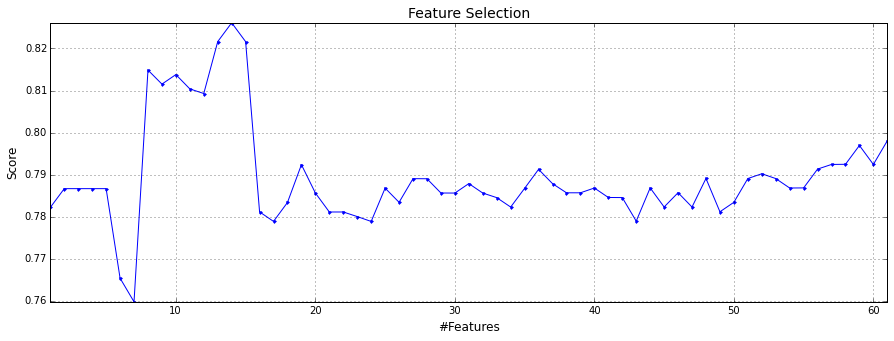

In [78]:
scoresCV=[]
scores=[]
for i in range(1,len(param_df)):
    new_df=df[param_df.index[0:i+1].values]
    X=new_df.ix[:,1::]
    y=new_df.ix[:,0]
    clf=DecisionTreeClassifier()
    scoreCV=sklearn.cross_validation.cross_val_score(clf,X,y,cv=10)
    scores.append(np.mean(scoreCV))

plt.figure(figsize=(15,5))
plt.plot(range(1,len(scores)+1),scores,'.-')
plt.axis("tight")
plt.title('Feature Selection',fontsize=14)
plt.xlabel('#Features',fontsize=12)
plt.ylabel('Score',fontsize=12)
plt.grid();

Based on the plot, a feature space of 10 dimensions provides the most reliable result while avoiding overfit.

In [79]:
best_features=param_df.index[1:10+1].values
print('Best features:\t',best_features)

('Best features:\t', array(['Title_Mr', 'Sex_female', 'Sex_male', 'Title_Mrs', 'Title_Miss',
       'Pclass_3', 'Pclass_1', 'Fare', 'Embarked_C', 'Embarked_S'], dtype=object))


Visualize the best features:

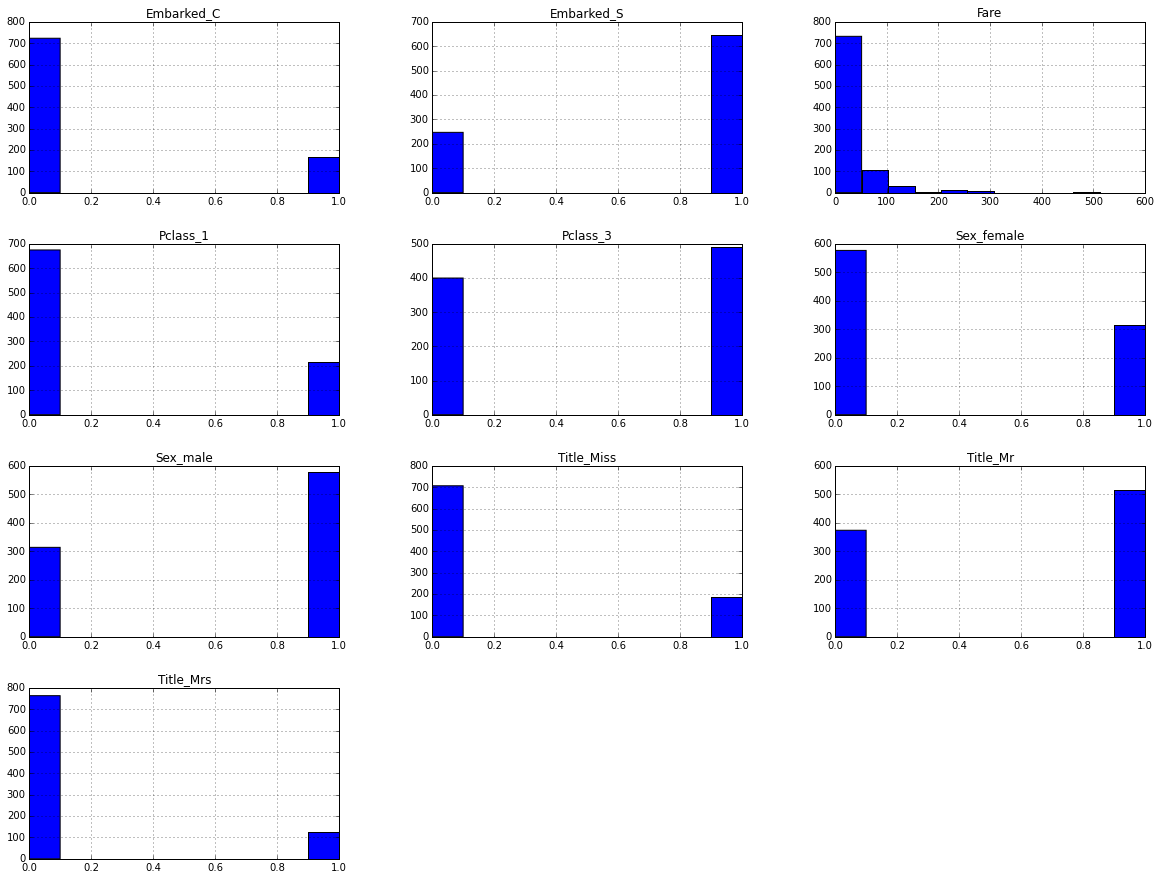

In [80]:
df[best_features].hist(figsize=(20,15));

Create the train and test datasets.

In [81]:
X=df[best_features]
y=df['Survived']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=44)

Decision Tree: analyze the different parameters of Decision Trees. 

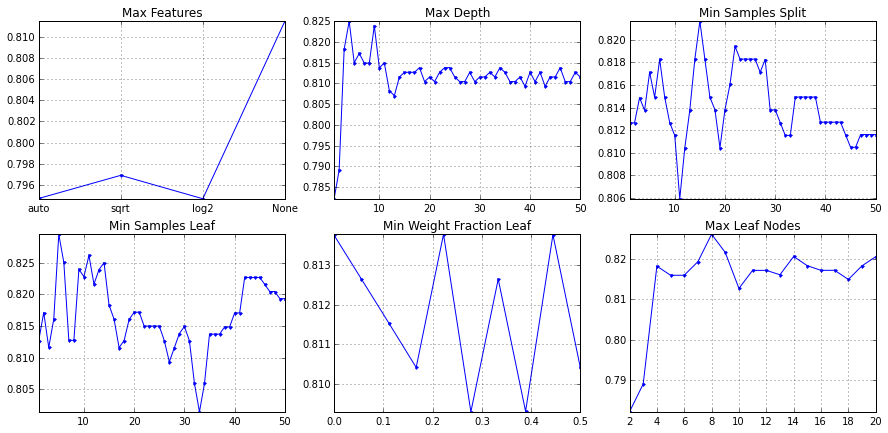

In [87]:
plt.figure(figsize=(15,7))

#Max Features
plt.subplot(2,3,1)
feature_param=['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf=DecisionTreeClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV=sklearn.cross_validation.cross_val_score(clf,X,y,cv=10)
    scores.append(np.mean(scoreCV))
plt.plot(scores,'.-')
plt.axis('tight')
plt.title('Max Features')
plt.xticks(range(len(feature_param)),feature_param)
plt.grid();

#Max Depth
plt.subplot(2,3,2)
feature_param=range(1,51)
scores=[]
for feature in feature_param:
    clf=DecisionTreeClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV=sklearn.cross_validation.cross_val_score(clf,X,y,cv=10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param,scores,'.-')
plt.axis('tight')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(2,3,3)
feature_param=range(1,51)
scores=[]
for feature in feature_param:
    clf=DecisionTreeClassifier(min_samples_split=feature)
    clf.fit(X_train,y_train)
    scoreCV=sklearn.cross_validation.cross_val_score(clf,X,y,cv=10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param,scores,'.-')
plt.axis('tight')
plt.title('Min Samples Split')
plt.grid();

#Min Samples Leaf
plt.subplot(2,3,4)
feature_param=range(1,51)
scores=[]
for feature in feature_param:
    clf=DecisionTreeClassifier(min_samples_leaf=feature)
    clf.fit(X_train,y_train)
    scoreCV=sklearn.cross_validation.cross_val_score(clf,X,y,cv=10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param,scores,'.-')
plt.axis('tight')
plt.title('Min Samples Leaf')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(2,3,5)
feature_param=np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf=DecisionTreeClassifier(min_weight_fraction_leaf=feature)
    clf.fit(X_train,y_train)
    scoreCV=sklearn.cross_validation.cross_val_score(clf,X,y,cv=10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param,scores,'.-')
plt.axis('tight')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(2,3,6)
feature_param=range(2,21)
scores=[]
for feature in feature_param:
    clf=DecisionTreeClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV=sklearn.cross_validation.cross_val_score(clf,X,y,cv=10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param,scores,'.-')
plt.axis('tight')
plt.title('Max Leaf Nodes')
plt.grid();

Max Depth show high score variance with change in parameter, while other parameters show low score variance. 

Random Forest Classifier

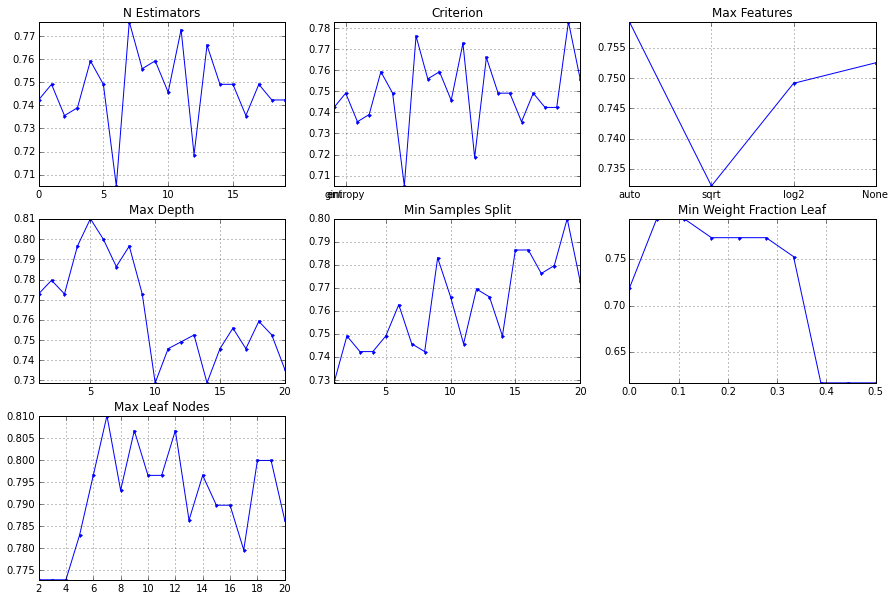

In [92]:
plt.figure(figsize=(15,10))
#N Estimators
plt.subplot(3,3,1)
feature_param=range(1,21)
scores=[]
for feature in feature_param:
    clf=RandomForestClassifier(n_estimators=feature)
    clf.fit(X_train,y_train)
    scoreCV=clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores,'.-')
plt.axis('tight')
plt.title('N Estimators')
plt.grid();

#Criterion
plt.subplot(3,3,2)
feature_param=['gini','entropy']
score=[]
for feature in feature_param:
    clf=RandomForestClassifier(criterion=feature)
    clf.fit(X_train,y_train)
    scoreCV=clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores,'.-')
plt.axis('tight')
plt.title('Criterion')
plt.xticks(range(len(feature_param)),feature_param)
plt.grid();

#Max Features
plt.subplot(3,3,3)
feature_param=['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf=RandomForestClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV=clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores,'.-')
plt.axis('tight')
plt.title('Max Features')
plt.xticks(range(len(feature_param)),feature_param)
plt.grid();

#Max Depth
plt.subplot(3,3,4)
feature_param=range(1,21)
scores=[]
for feature in feature_param:
    clf=RandomForestClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV=clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param,scores,'.-')
plt.axis('tight')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(3,3,5)
feature_param=range(1,21)
scores=[]
for feature in feature_param:
    clf=RandomForestClassifier(min_samples_split=feature)
    clf.fit(X_train,y_train)
    scoreCV=clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param,scores,'.-')
plt.axis('tight')
plt.title('Min Samples Split')
plt.grid();

#Min Weight Fraction LEaf
plt.subplot(3,3,6)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(3,3,7)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Max Leaf Nodes')
plt.grid();


Random Forest seems to show high variance in scores with most parameter changes.
Max Features, Criterion and Max Leaf Nodes show low variance in scores.
The general high varience in N Estimator plot shows the risk of overfitting.

Gradient Boosting